In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import Normalizer
import shap
from sklearn.pipeline import make_pipeline
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit,StratifiedKFold
from sklearn.svm import SVC
from sklearn import svm
from sklearn.model_selection import cross_val_score
import os
from sklearn.pipeline import Pipeline
from typing import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc
import matplotlib
from scipy.stats import gmean



In [10]:
# Load and prepare data
file_path = "D:\cddvd\sedex_vms_zhong.xlsx"#Please enter the path to the Supplementary data 3
data = pd.read_excel(file_path)
df = data[['Deposit type', 'Co', 'Ni', 'Zn', 'Cd', 'Sb', 'Pb', 'Ag', 'Se']]
X = df.copy(deep=True)
y = X.pop('Deposit type')
# Print class distribution
print(y.value_counts())
y_int, index = pd.factorize(y, sort=True)
y = y_int

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)



# Models to be used for training
models = (
    svm.SVC(kernel='linear', C=1),
    svm.SVC(kernel='rbf', C=1)
)

# Cross-validation scores for each model
for clf in models:
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)
    print(f'{scores.mean():2.2f} ± {scores.std():2.2f}')

# Create a pipeline with SVC
pipe_clf = make_pipeline(svm.SVC(cache_size=1000, class_weight=None, probability=True))

# Define a custom normalizer class
class MidpointNormalize(Normalizer):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# Set ranges for C and gamma parameters
C_range = np.logspace(-2, 5, 8, base=10)
gamma_range = np.logspace(-7, -2, 6, base=10)

# Define parameter grid for GridSearchCV
param_grid = {
    "svc__kernel": ["rbf"],
    "svc__gamma": gamma_range,
    "svc__C": C_range
}

# Grid search with cross-validation
grid = GridSearchCV(pipe_clf, param_grid=param_grid, cv=10, scoring="f1_macro", n_jobs=-1, refit=True)
grid.fit(X_train, y_train)

# Print best parameters and score
print(f"The best parameters are {grid.best_params_} with a score of {grid.best_score_:0.2f}")

# Print cross-validation scores
print("\nCross-validation scores:")
means = grid.cv_results_['mean_test_score']
stds = grid.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print(f"{mean:0.3f} (+/-{std*2:0.03f}) for {params}")

# Make predictions
y_test_pred = grid.predict(X_test)
t_train_pred = grid.predict(X_train)
y_test_proba = grid.predict_proba(X_test)[:, 1]
# Print classification report for the training set
print("Training set report:")
print(classification_report(y_train, t_train_pred))
print("Test set report:")
print(classification_report(y_test, y_test_pred, output_dict=False))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))
report_filename = r"D:\cddvd\SVMccp_report.txt"  # Specify the file path and name
# Final evaluation on test set
print("\nFinal Evaluation:")
print(classification_report(y_test, y_test_pred, output_dict=False))
print(confusion_matrix(y_test, y_test_pred))

Deposit type
SEDEX    555
VMS      531
Name: count, dtype: int64
0.95 ± 0.02
0.46 ± 0.02
The best parameters are {'svc__C': 10000.0, 'svc__gamma': 1e-06, 'svc__kernel': 'rbf'} with a score of 0.96

Cross-validation scores:
0.335 (+/-0.003) for {'svc__C': 0.01, 'svc__gamma': 1e-07, 'svc__kernel': 'rbf'}
0.509 (+/-0.097) for {'svc__C': 0.01, 'svc__gamma': 1e-06, 'svc__kernel': 'rbf'}
0.837 (+/-0.069) for {'svc__C': 0.01, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}
0.629 (+/-0.078) for {'svc__C': 0.01, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.335 (+/-0.003) for {'svc__C': 0.01, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.335 (+/-0.003) for {'svc__C': 0.01, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
0.498 (+/-0.088) for {'svc__C': 0.1, 'svc__gamma': 1e-07, 'svc__kernel': 'rbf'}
0.863 (+/-0.052) for {'svc__C': 0.1, 'svc__gamma': 1e-06, 'svc__kernel': 'rbf'}
0.881 (+/-0.050) for {'svc__C': 0.1, 'svc__gamma': 1e-05, 'svc__kernel': 'rbf'}
0.879 (+/-0.090) for {'svc__C': 0.1, 'svc__gamma': 

X does not have valid feature names, but SVC was fitted with feature names
Using 868 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/868 [00:00<?, ?it/s]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 1/868 [00:02<35:22,  2.45s/it]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 2/868 [00:04<34:48,  2.41s/it]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
  0%|          | 3/868 [00:07<35:43,  2.48s/it]X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitte

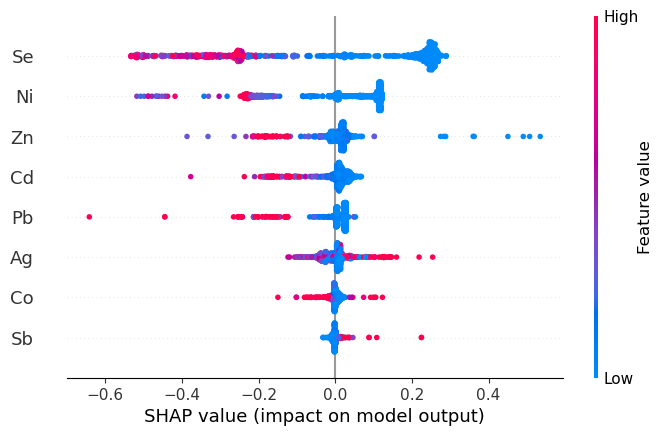

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


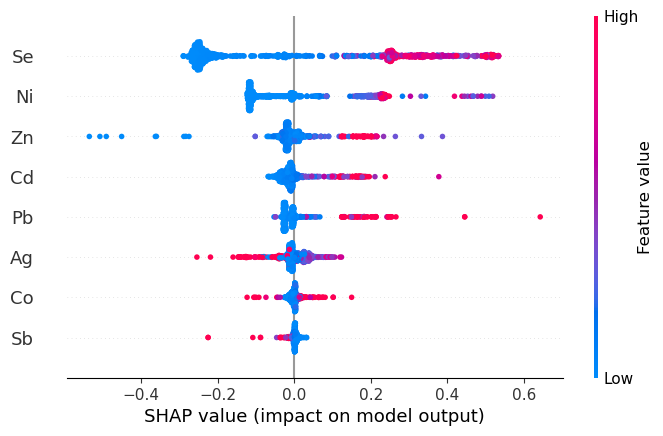

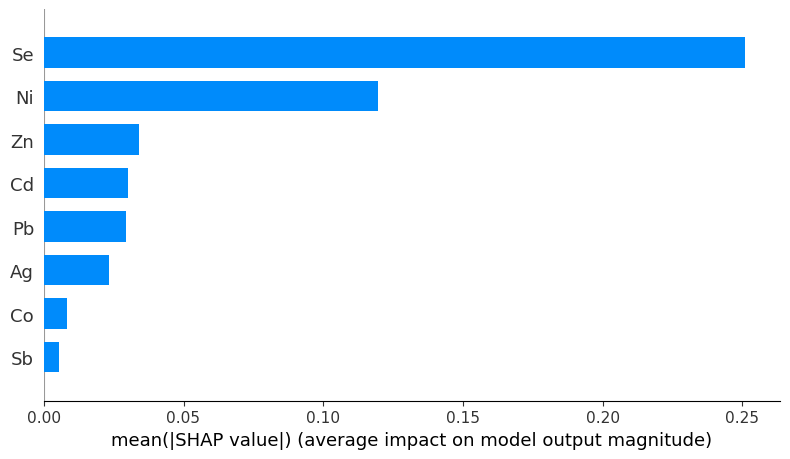

In [11]:
# Get the trained SVC model from the grid search
svc_model = grid.best_estimator_.named_steps["svc"]

# Define a prediction function using the trained SVC model
def predict_function(X):
    return svc_model.predict_proba(X)

# Create a SHAP explainer using KernelExplainer
explainer = shap.KernelExplainer(predict_function, X_train)
shap_values = explainer.shap_values(X_train)

# Plot SHAP Bee Swarm plots for each class
for i, class_name in enumerate(['No Deposit', 'Deposit']):
    shap_exp = shap.Explanation(
        base_values=explainer.expected_value,
        values=shap_values[i],
        data=X_train,
        feature_names=X_train.columns
    )
    shap.plots.beeswarm(shap_exp, max_display=10)  # Show top 10 features
    plt.title(f'SHAP Bee Swarm Plot for {class_name}')
    plt.savefig(f'D:/cddvd/SHAP_beeswarm_{class_name}.jpg', dpi=600, format='jpg')
    plt.close()  # Close the current plot
# Plot SHAP summary plot (showing feature impacts on predictions)
shap.summary_plot(shap_values[1], X_train, plot_type="bar")


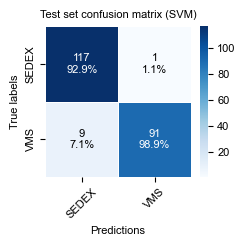

In [13]:
# Define label order
label_order = ["SEDEX", "VMS"]
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, columns=label_order, index=label_order)
cm_df_percentage = cm_df.div(cm_df.sum(axis=0), axis=1) * 100
plt.figure(figsize=(2.5, 2.5))
plt.rc('font', family='Arial', size=8)
ax = sns.heatmap(cm_df, linewidths=.5, ax=plt.gca(), cmap="Blues")
norm = plt.Normalize(vmin=cm_df.values.min(), vmax=cm_df.values.max())
sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)

for i in range(len(cm_df)):
    for j in range(len(cm_df)):
        value = cm_df.iloc[i, j]
        percentage = cm_df_percentage.iloc[i, j]
        color = 'white' if sm.to_rgba(value)[0:3] < (0.5, 0.5, 0.5) else 'black'  # Choose text color based on cell color
        plt.text(j + 0.5, i + 0.5, f"{value}\n{percentage:.1f}%",
                 ha='center', va='center', color=color, family='Arial', size=8)
plt.title("Test set confusion matrix (SVM)", fontsize=8)
plt.xlabel("Predictions", fontsize=8)
plt.ylabel("True labels", fontsize=8)

ax.set_xticklabels(label_order, rotation=45, fontsize=8)
ax.set_yticklabels(label_order, fontsize=8)
plt.tight_layout()
plt.savefig(r'D:\cddvd\confusion_matrix_SVM_ccp.svg', dpi=600, format='svg')
plt.savefig(r'D:\cddvd\confusion_matrix_SVM_ccp.pdf', dpi=600, format='pdf')
plt.show()


In [ ]:
print(
    """
RF classifier to predict the genetic classes of the chalcopyrite source with "Co", "Ni", "Zn", "Sb", "Pb", "Ag", "Se", "Cd"values,
Please enter the path of the .xlsx data file.(for example: /path/to/file/example_data.xlsx )
The data are supposed to contain all the 8 features above for prediction.
If any one of the features is missing in a sample, that sample will be discarded.
The columns' names of Co, Ni, Zn, Cd, Sb, Pb, Ag, Se should be exactly as listed above without any prefix and suffix
and MAKE SURE this column name row is the FIRST row.
"""
)
data_file_path = r"D:\我的论文\dongshengmiao_knn_ccp.xlsx"#Please enter the path to the data file
df = pd.read_excel(data_file_path)
index = ['SEDEX', 'VMS']
elements = [ "Co","Ni","Zn", "Cd", "Sb", "Pb","Ag","Se"]
for element in elements:
    df[element] = pd.to_numeric(df[element], errors="coerce")

to_predict = df.loc[:, elements].dropna()
to_predict.reset_index(drop=True, inplace=True)
print(f"{to_predict.shape[0]} samples available")
print(to_predict.describe())
predict_res = grid.predict(to_predict)
predict_res = list(predict_res)
for i, ind in enumerate(predict_res):
    predict_res[i] = index[ind]

c: Counter[str] = Counter(predict_res)
if not c:
    input("no sample with the 8 features detected!")
    raise SystemExit()
    
proba = grid.predict_proba(to_predict)
predict_res = np.array(predict_res)
predict_res = predict_res.reshape((predict_res.shape[0], 1))
res = np.concatenate([predict_res, proba], axis=1)
res = pd.DataFrame(res, columns=['pred_chalcopyrite_type', 'SEDEX_proba', 'VMS_proba'])
pd.set_option('display.max_columns', 10)
print('Detailed report preview:\n', res)
print("The samples are predicted respectively to be: ")
print(c.most_common(), "\n")
print(
    f"The most possible type of the group of samples is: {c.most_common(1)[0][0]}.\n"
)
if input('Save report? (y/n): ').lower() == 'y':
    base_filename = os.path.basename(data_file_path)
    prefix, _ = os.path.splitext(base_filename)
    save_name = prefix + '_resultSVMccp.xlsx'
    res2 = pd.concat([to_predict['Pb'], res], axis=1, )
    output = df.join(res2.set_index('Pb'), on='Pb')
    output.to_excel(save_name)
    print(f'{save_name} saved.')
input("Press any key to exit.")